* Сбор данных
 *    Краулинг
 *    Парсинг
* Очистка данных
 *    Обработка пропусков
 *    Приведение к единому формату
* Разведочный анализ
* Моделирование и интерпретация результатов

In [6]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

import pandas as pd
import time

from tqdm import tqdm_notebook
from ftfy import fix_text

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Кроулинг

In [5]:
main_link = "https://krisha.kz/prodazha/kvartiry/astana-esilskij/?das[_sys.hasphoto]=1&das[checked]=1&das[novostroiki]=1&das[who]=1&page="

In [14]:
response = requests.get(main_link, headers={"User-Agent": UserAgent().chrome})

In [44]:
def get_soup(page_link):
    response = requests.get(page_link, headers={"User-Agent": UserAgent().chrome})
    soup = BeautifulSoup(response.content, "html.parser")
    return soup
    

In [18]:
soup = get_soup(main_link + str(3))

In [22]:
link_raw = soup.findAll("a", attrs={"class", "a-card__title"})

In [27]:
links = [i["href"] for i in link_raw]
# links

In [28]:
def get_link(page_number):
    soup =get_soup(main_link+str(page_number))
    link_raw = soup.findAll("a", attrs={"class", "a-card__title"})
    links = [i["href"] for i in link_raw]
    return links

In [30]:
get_link(5)

['/a/show/57880188',
 '/a/show/57780018',
 '/a/show/57491912',
 '/a/show/57555600',
 '/a/show/57382528',
 '/a/show/57808725',
 '/a/show/56915724',
 '/a/show/57835263',
 '/a/show/55673664',
 '/a/show/57340304',
 '/a/show/56294579',
 '/a/show/57834987',
 '/a/show/57834724',
 '/a/show/57863615',
 '/a/show/28389083',
 '/a/show/57548637',
 '/a/show/56688984',
 '/a/show/57713812',
 '/a/show/57784303',
 '/a/show/56431953',
 '/a/show/57663539']

In [33]:
# all_links = []
# for i in range(533):
#     links = get_link(i)
#     all_links.append(links)
    

In [45]:
with open('all_links.pkl', 'rb') as f:
    all_links = pickle.load(f)

In [36]:
len(all_links)

10802

# Парсинг

In [46]:
page_link = "https://krisha.kz"
main_soup = get_soup("https://krisha.kz/a/show/57859710")

In [48]:
main_soup.find("div", attrs={'class': 'offer__price'}).text

'\n                                                                                                            13\xa0000\xa0000\xa0〒\n'

## _get_price

In [49]:
def _get_price(main_soup):
    try:
        price = main_soup.find("div", attrs={'class': 'offer__price'}).text
        price = fix_text(price, normalization='NFKC')
        price = price.replace("〒", "").strip()
        price = price.replace(" ", "").strip()
        price = int(price)
    except:
        price = np.nan
    return price

_get_price(main_soup)

13000000

## _get_rooms

In [50]:
def _get_rooms(main_soup):
    try:
        tittle = main_soup.find("h1")
        tittle = tittle.text.strip()
        tittle = tittle.split(",")[0]
        tittle = tittle.replace("-комнатная квартира", "")
        tittle = int(tittle)
    except:
        tittle = np.nan
    return tittle

_get_rooms(main_soup)

3

## _get_house_name

In [51]:
def _get_house_name(main_soup):
    try:
        house_name = main_soup.find("div", attrs={'data-name': 'map.complex'})
        house_name = house_name.text.replace("Жилой комплекс", "").strip()
    except:
        house_name = np.nan
    return house_name

_get_house_name(main_soup)

nan

## _get_square

In [52]:
def _get_square(main_soup):
    try:
        square = main_soup.find("div", {"data-name": "live.square"}).text
        square = [int(s) for s in square.split() if s.isdigit()]
    except:
        square = np.nan
    
    return square

_get_square(main_soup)

[60, 6]

## _get_ceiling

In [53]:
def _get_ceiling(main_soup):
    try:
        ceiling = main_soup.find("div", {"data-name": "ceiling"})
        ceiling = ceiling.text.replace("Потолки", "").replace("м", "").strip()
        ceiling = int(ceiling)
    except:
        ceiling = np.nan
    return ceiling

_get_ceiling(main_soup)

nan

## _get_year_built

In [54]:
def _get_year_built(main_soup):
    try:
        year_built = main_soup.find("div", {"data-name": "flat.building"}).text
        year_built = [int(s) for s in year_built.split() if s.isdigit()][0]
    except:
        year_built = np.nan
    return year_built

_get_year_built(main_soup)

1975

## _get_floor

In [55]:
def _get_floor(main_soup):
    try:
        floor = main_soup.find("div", {"data-name": "flat.floor"})
        floor = floor.text.replace("Этаж", "").strip().split(" из ")
    except:
        floor = np.nan
        
    return floor

_get_floor(main_soup)

['3', '5']

## _get_renovation

In [56]:
def _get_renovation(main_soup):
    try:
        renovation = main_soup.find("div", {"data-name": "flat.renovation"})
        renovation = renovation.text.replace("Состояние", "").strip()
    except:
        renovation = np.nan
    return renovation

_get_renovation(main_soup)

'среднее'

# Объединение

In [57]:
def get_page_info(link):
    main_soup = get_soup(page_link + link)
    
    price = _get_price(main_soup)
    renovation = _get_renovation(main_soup)
    floor = _get_floor(main_soup)
    year_built = _get_year_built(main_soup)
    ceiling= _get_ceiling(main_soup)
    square = _get_square(main_soup)
    rooms = _get_rooms(main_soup)
    house_name = _get_house_name(main_soup)
    
    
    info = {
        'price': price,
        'renovation':renovation,
        'floor':floor,
        'year_built':year_built,
        'ceiling':ceiling,
        'square':square,
        'rooms':rooms,
        'house_name':house_name,
    }
    
    return info

In [58]:
get_page_info('/a/show/57859710')

{'price': 13000000,
 'renovation': 'среднее',
 'floor': ['3', '5'],
 'year_built': 1975,
 'ceiling': nan,
 'square': [60, 6],
 'rooms': 3,
 'house_name': nan}

In [60]:
# news_dataset = pd.DataFrame(columns=['renovation', 'floor', 'year_built', 'ceiling', 'square', 'rooms', 'house_name'])

# for link in tqdm_notebook(all_links):
#     news_dataset = news_dataset.append(get_page_info(link), ignore_index=True)
#     time.sleep(0.1)

# Очистка данных

In [61]:
data = pd.read_pickle("news_dataset.pkl").drop("priv_dorm", axis=1)
print(data.shape)
data.head()

(10802, 8)


,renovation,floor,year_built,ceiling,square,rooms,house_name,price
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"[7, 22]",2019,NaN,[42],1,Коркем Tower,15000000.0
2,черновая отделка,"[4, 9]",2020,NaN,[],1,NaN,8305500.0
3,евроремонт,"[4, 10]",2013,NaN,[87],2,Нурсая Бонита,38000000.0
4,хорошее,"[4, 12]",2007,NaN,[70],3,7 Бочек,24000000.0


## Обработка пропусков

In [62]:
data = data[data.price.isna()==False]

In [63]:
data.price = data.price / 1000000
data.head(3)

,renovation,floor,year_built,ceiling,square,rooms,house_name,price
1,NaN,"[7, 22]",2019,NaN,[42],1,Коркем Tower,15.0000
2,черновая отделка,"[4, 9]",2020,NaN,[],1,NaN,8.3055
3,евроремонт,"[4, 10]",2013,NaN,[87],2,Нурсая Бонита,38.0000


In [64]:
data.square.fillna("[]", inplace=True)
data.floor.fillna("[]", inplace=True)

In [65]:
# data.ceiling.value_counts()

In [66]:
data.ceiling = data.ceiling.fillna(2.75)
data.head(3)

,renovation,floor,year_built,ceiling,square,rooms,house_name,price
1,NaN,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000
2,черновая отделка,"[4, 9]",2020,2.75,[],1,NaN,8.3055
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000


In [68]:
data.house_name.fillna("Unknown", inplace=True)
data.head(3)

,renovation,floor,year_built,ceiling,square,rooms,house_name,price
1,NaN,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000
2,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000


In [69]:
data.renovation.fillna("Unknown", inplace=True)
data.head(3)

,renovation,floor,year_built,ceiling,square,rooms,house_name,price
1,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000
2,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000


## Приведение к единому формату / Новые переменные

In [70]:
data.head(3)

,renovation,floor,year_built,ceiling,square,rooms,house_name,price
1,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000
2,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000


In [72]:
data["house_age"] = 2020 - data["year_built"].astype(int)
data.head(7)

,renovation,floor,year_built,ceiling,square,rooms,house_name,price,house_age
1,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,1
2,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,0
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,7
4,хорошее,"[4, 12]",2007,2.75,[70],3,7 Бочек,24.0000,13
5,Unknown,"[1, 3]",2021,2.75,[8],1,МЖК Астана,5.5980,-1
6,черновая отделка,"[9, 9]",2020,2.75,[88],3,Panorama Park,32.5000,0
7,хорошее,"[7, 9]",2017,2.75,[70],2,Unknown,20.0000,3


In [73]:
square_total, square_living, square_kitchen = [], [], []
for ind, row in data.iterrows():
    if "]" in row["square"]:
        i = []
    else:
        i = row["square"]
        j = int(row["rooms"]) * 30
    square_n = len(i)
    if square_n==0:
        square_total.append(j)
        square_living.append(j * 70 / 100)
        square_kitchen.append(j * 20 / 100)
    elif square_n==1:
        square_total.append(i[0])
        square_living.append(j * 70 / 100)
        square_kitchen.append(j * 20 / 100)
    elif square_n==2:
        square_total.append(i[0])
        square_living.append(i[1])
        square_kitchen.append(j * 20 / 100)
    elif square_n==3:
        square_total.append(i[0])
        square_living.append(i[1])
        square_kitchen.append(i[2])
        
data["square_total"] = square_total
data["square_living"] = square_living
data["square_kitchen"] = square_kitchen

data.head()

,renovation,floor,year_built,ceiling,square,rooms,house_name,price,house_age,square_total,square_living,square_kitchen
1,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,1,42,21.0,6.0
2,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,0,30,21.0,6.0
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,7,87,42.0,12.0
4,хорошее,"[4, 12]",2007,2.75,[70],3,7 Бочек,24.0000,13,70,63.0,18.0
5,Unknown,"[1, 3]",2021,2.75,[8],1,МЖК Астана,5.5980,-1,8,21.0,6.0


In [74]:
floor_flat, floors_total = [], []
for i in data.floor:
    if i == '[]':
        i = []
    floor_n = len(i)
    if floor_n == 0:
        floor_flat.append(np.nan)
        floors_total.append(np.nan)
    elif floor_n==1:
        floor_flat.append(int(i[0]))
        floors_total.append(np.nan)
    elif floor_n==2:
        floor_flat.append(int(i[0]))
        floors_total.append(int(i[1]))
        
data["floor_flat"] = floor_flat
data["floors_total"] = floors_total

data.head()

,renovation,floor,year_built,ceiling,square,rooms,house_name,price,house_age,square_total,square_living,square_kitchen,floor_flat,floors_total
1,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,1,42,21.0,6.0,7.0,22.0
2,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,0,30,21.0,6.0,4.0,9.0
3,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,7,87,42.0,12.0,4.0,10.0
4,хорошее,"[4, 12]",2007,2.75,[70],3,7 Бочек,24.0000,13,70,63.0,18.0,4.0,12.0
5,Unknown,"[1, 3]",2021,2.75,[8],1,МЖК Астана,5.5980,-1,8,21.0,6.0,1.0,3.0


In [75]:
data.year_built = data.year_built.astype(int)
data.rooms = data.rooms.astype(int)

In [76]:
data.drop(["floor", "square", "year_built"], axis=1, inplace=True)
data.head(3)

,renovation,ceiling,rooms,house_name,price,house_age,square_total,square_living,square_kitchen,floor_flat,floors_total
1,Unknown,2.75,1,Коркем Tower,15.0000,1,42,21.0,6.0,7.0,22.0
2,черновая отделка,2.75,1,Unknown,8.3055,0,30,21.0,6.0,4.0,9.0
3,евроремонт,2.75,2,Нурсая Бонита,38.0000,7,87,42.0,12.0,4.0,10.0


# Разведочный анализ

In [77]:
data.info()
data[data.square_total==0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10534 entries, 1 to 10801
Data columns (total 11 columns):
renovation        10534 non-null object
ceiling           10534 non-null float64
rooms             10534 non-null int64
house_name        10534 non-null object
price             10534 non-null float64
house_age         10534 non-null int64
square_total      10534 non-null int64
square_living     10534 non-null float64
square_kitchen    10534 non-null float64
floor_flat        9801 non-null float64
floors_total      9615 non-null float64
dtypes: float64(6), int64(3), object(2)
memory usage: 987.6+ KB


,renovation,ceiling,rooms,house_name,price,house_age,square_total,square_living,square_kitchen,floor_flat,floors_total


In [78]:
data["price_square"] = round(data["price"] * 1000000 / data["square_total"],2)
data.head()

,renovation,ceiling,rooms,house_name,price,house_age,square_total,square_living,square_kitchen,floor_flat,floors_total,price_square
1,Unknown,2.75,1,Коркем Tower,15.0000,1,42,21.0,6.0,7.0,22.0,357142.86
2,черновая отделка,2.75,1,Unknown,8.3055,0,30,21.0,6.0,4.0,9.0,276850.00
3,евроремонт,2.75,2,Нурсая Бонита,38.0000,7,87,42.0,12.0,4.0,10.0,436781.61
4,хорошее,2.75,3,7 Бочек,24.0000,13,70,63.0,18.0,4.0,12.0,342857.14
5,Unknown,2.75,1,МЖК Астана,5.5980,-1,8,21.0,6.0,1.0,3.0,699750.00


In [79]:
data.house_name.value_counts().to_frame("cnt").sort_values(by="cnt" , ascending=False).head(15)

,cnt
Unknown,2592
Nova City,300
Венский квартал,151
Арнау,146
Adal,138
College,137
Manhattan,134
Panorama Park,134
Sezim Qala,133
Времена года. Лето,132


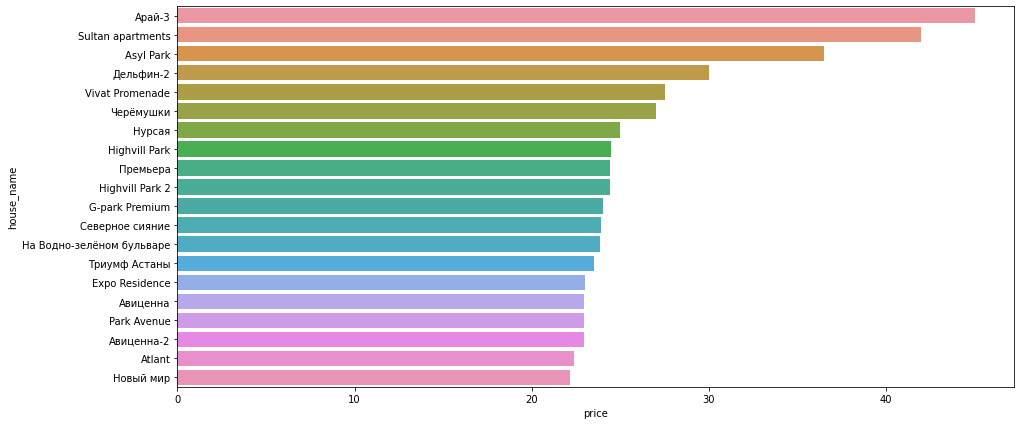

In [80]:
# 1х комнатная
table = data[data.rooms==1].groupby("house_name").agg({"price": "mean"}).reset_index(
).sort_values(by="price", ascending=False).head(20)
plt.figure(figsize=(15,7))
sns.barplot(data=table, x="price", y = "house_name")
plt.show()

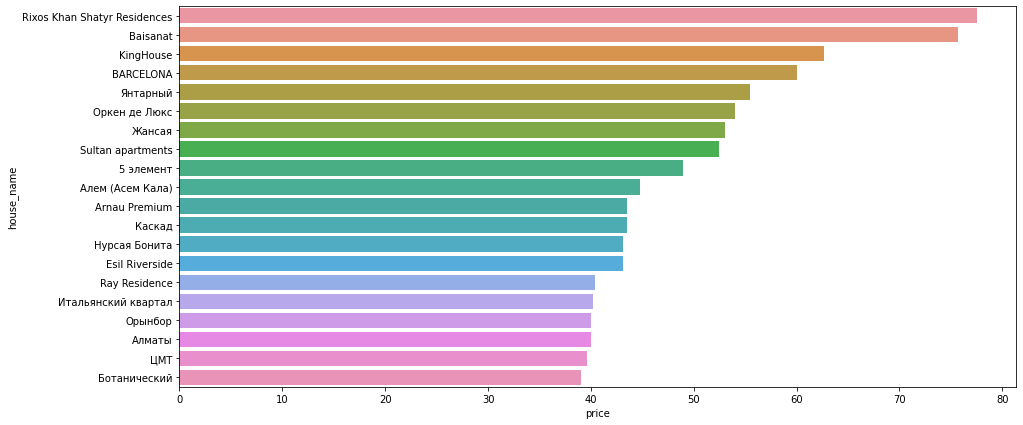

In [81]:
# 2х комнатная
table = data[data.rooms==2].groupby("house_name").agg({"price": "mean"}).reset_index(
).sort_values(by="price", ascending=False).head(20)
plt.figure(figsize=(15,7))
sns.barplot(data=table, x="price", y = "house_name")
plt.show()

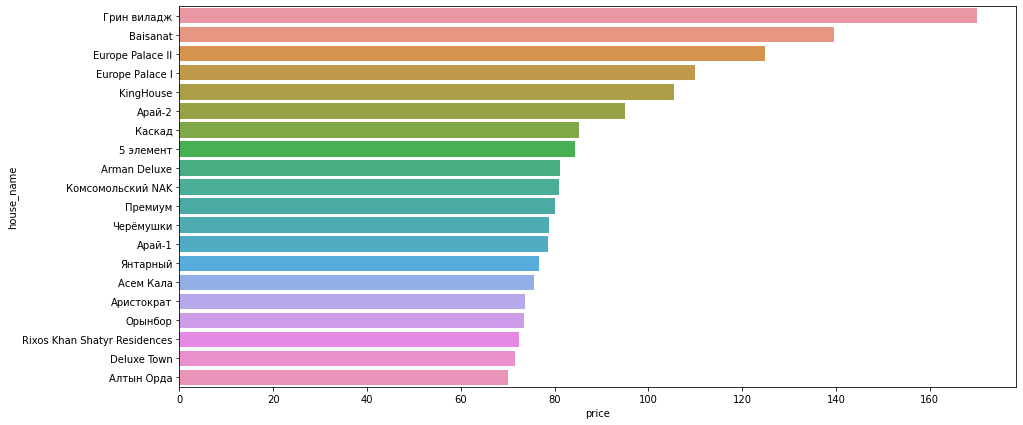

In [82]:
#3х комнатная
table = data[data.rooms==3].groupby("house_name").agg({"price": "mean"}).reset_index(
).sort_values(by="price", ascending=False).head(20)
plt.figure(figsize=(15,7))
sns.barplot(data=table, x="price", y = "house_name")
plt.show()

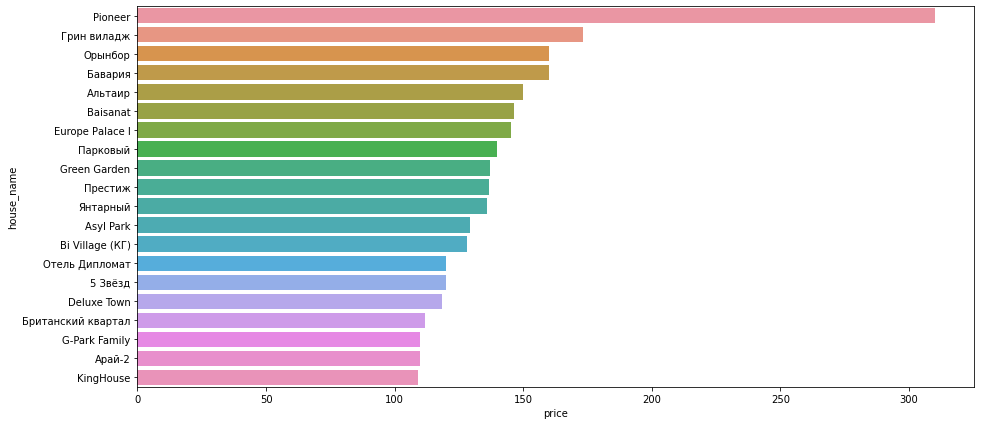

In [83]:
# 4х комнатная
table = data[data.rooms==4].groupby("house_name").agg({"price": "mean"}).reset_index(
).sort_values(by="price", ascending=False).head(20)
plt.figure(figsize=(15,7))
sns.barplot(data=table, x="price", y = "house_name")
plt.show()

1 - комнатная


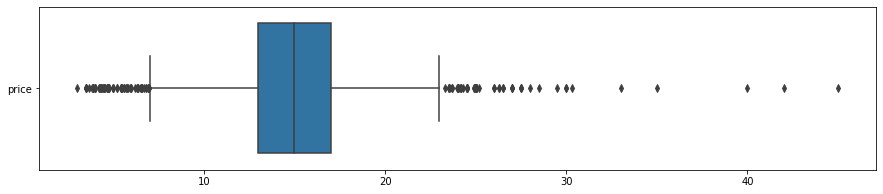

2 - комнатная


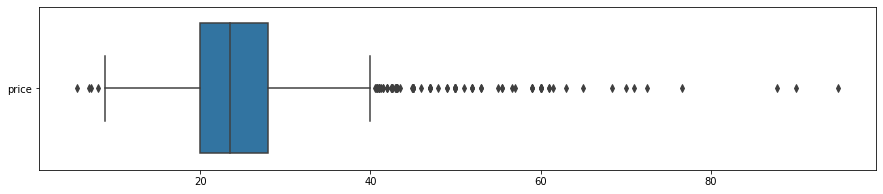

3 - комнатная


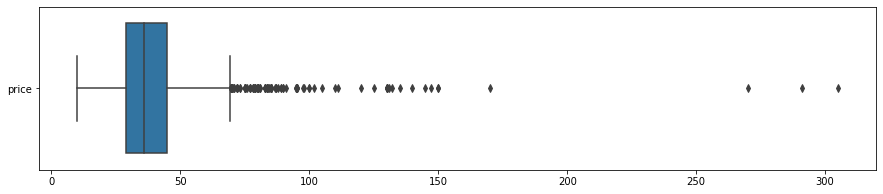

4 - комнатная


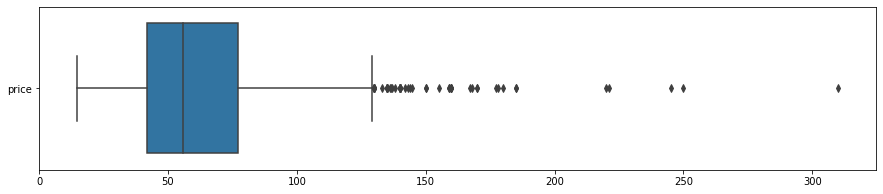

5 - комнатная


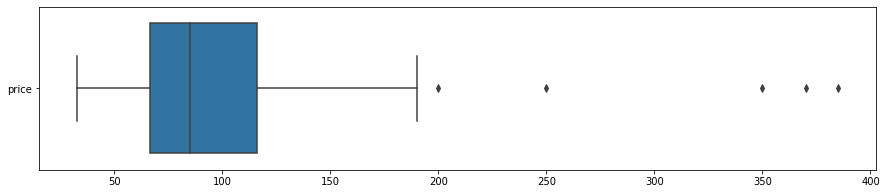

6 - комнатная


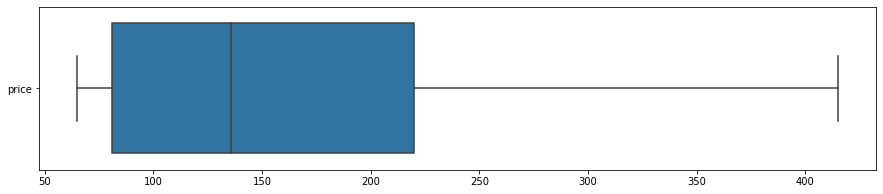

In [84]:
for i in range(1,7):
    print("{} - комнатная".format(i))
    plt.figure(figsize=(15,3))
    sns.boxplot(data=data[data.rooms==i][["price"]], orient="h")
    plt.show()

# Моделирование и интерпретация результатов

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10534 entries, 1 to 10801
Data columns (total 12 columns):
renovation        10534 non-null object
ceiling           10534 non-null float64
rooms             10534 non-null int64
house_name        10534 non-null object
price             10534 non-null float64
house_age         10534 non-null int64
square_total      10534 non-null int64
square_living     10534 non-null float64
square_kitchen    10534 non-null float64
floor_flat        9801 non-null float64
floors_total      9615 non-null float64
price_square      10534 non-null float64
dtypes: float64(7), int64(3), object(2)
memory usage: 1.0+ MB


In [87]:
data.drop("house_name", axis=1, inplace=True)

In [88]:
data.dropna(inplace=True)

In [89]:
scaler = StandardScaler()
m_linear = LinearRegression()

In [92]:
data_renovation = pd.get_dummies(data["renovation"])

In [93]:
df = pd.concat([data, data_renovation], axis=1).drop("renovation", axis=1)

In [94]:
df = df[df.price<150]
df.head()

,ceiling,rooms,price,house_age,square_total,square_living,square_kitchen,floor_flat,floors_total,price_square,Unknown,евроремонт,свободная планировка,среднее,требует ремонта,хорошее,черновая отделка
1,2.75,1,15.0000,1,42,21.0,6.0,7.0,22.0,357142.86,1,0,0,0,0,0,0
2,2.75,1,8.3055,0,30,21.0,6.0,4.0,9.0,276850.00,0,0,0,0,0,0,1
3,2.75,2,38.0000,7,87,42.0,12.0,4.0,10.0,436781.61,0,1,0,0,0,0,0
4,2.75,3,24.0000,13,70,63.0,18.0,4.0,12.0,342857.14,0,0,0,0,0,1,0
5,2.75,1,5.5980,-1,8,21.0,6.0,1.0,3.0,699750.00,1,0,0,0,0,0,0


In [95]:
X = df.drop("price", axis=1)
y = df["price"]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7632, 16) (1908, 16) (7632,) (1908,)


In [97]:
m_linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
def model_scores(modelName):
    y_pred = modelName.predict(X_test)
    mse = "\nRMSE: {:.4f}".format(mean_squared_error(y_pred, y_test))
    rmse = "\nMSE: {:.4f}".format(math.sqrt(mean_squared_error(y_pred, y_test)))
    return mse, rmse

In [100]:
model_scores(m_linear)

('\nMSE: 127.3427', '\nMSE: 11.2846')

In [101]:
## Результат

In [102]:
y_pred = m_linear.predict(X_test)

result = pd.DataFrame([y_pred, y_test.values]).T
result.columns = ["actual", "predicted"]
result = result.reset_index()
result = pd.melt(result, id_vars=["index"], value_vars=["actual", "predicted"])

In [103]:
result = result.sort_values(by="index").head(50)

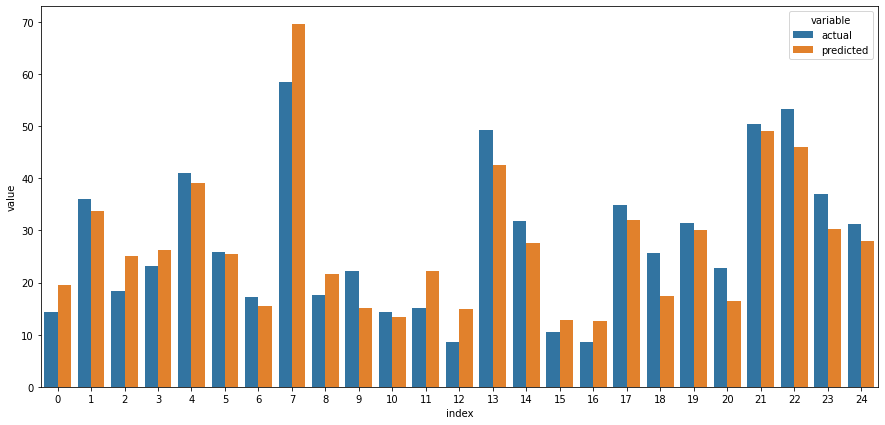

In [104]:
plt.figure(figsize=(15,7))
sns.barplot(x="index", hue="variable", y="value", data=result)

In [106]:
Importance = m_linear.coef_
Columns = X_train.columns

imp = pd.DataFrame([Columns, Importance]).T
imp.columns = ["feature", "coef"]
imp.sort_values(by="coef", inplace=True, ascending=False)
imp.head()

,feature,coef
0,ceiling,10.8685
10,евроремонт,3.50103
15,черновая отделка,0.522786
3,square_total,0.452079
14,хорошее,0.117607


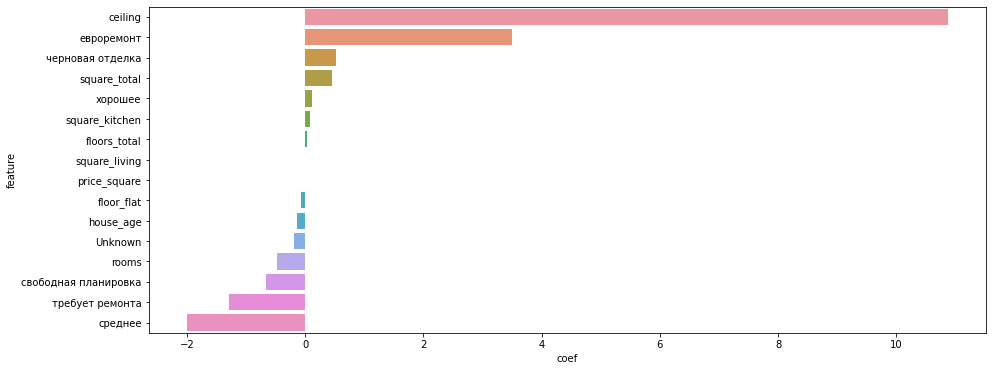

In [107]:
plt.figure(figsize=(15,6))
sns.barplot(data=imp, x="coef", y="feature")